# Meta Analysis about the Dataset

Reporters analyzed more than 22.3 million coordinates from flight paths published online by the Chula Vista Police Department to understand where drones were sent and why. Using data from an unsecured API, reporters were also able to analyze when the drones' cameras started recording and how high they flew. Reporters calculated the seconds each city block in Chula Vista was under law enforcement’s gaze and then estimated the exposure time to each resident who lives there. On average, each drone flight passes through 12 census blocks, exposing approximately 4,700 residents on its path to police drone monitoring. 


In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm, trange
from loguru import logger
import matplotlib.pyplot as plt

storage = "/Volumes/easystore/Drones/"

flight_details = pd.concat(
    [
        chunk
        for chunk in tqdm(
            pd.read_csv(
                f"{storage}/gpx-with-census-data.csv", chunksize=100000, dtype=str
            ),
            desc="Loading data",
        )
    ]
)
cv_flights = pd.concat(
    [
        chunk
        for chunk in tqdm(
            pd.read_csv(
                f"../../data/outputs/outputs_cv-flight-manifest.csv", chunksize=100000, dtype=str
            ),
            desc="Loading data",
        )
    ]
)
per_second = pd.concat(
    [
        chunk
        for chunk in tqdm(
            pd.read_csv(
                f"../../data/outputs/outputs_drone-seconds-block-count.csv", chunksize=100000, dtype=str
            ),
            desc="Loading data",
        )
    ]
)


per_day = pd.concat(
    [
        chunk
        for chunk in tqdm(
            pd.read_csv(
                f"../../data/outputs/outputs_cv-blocks-drones-calls.csv", chunksize=100000, dtype=str
            ),
            desc="Loading data",
        )
    ]
)
race_df = pd.concat(
    [
        chunk
        for chunk in tqdm(
            pd.read_csv(
                f"../../data/outputs/outputs_census-race.csv", chunksize=100000, dtype=str
            ),
            desc="Loading data",
        )
    ]
)
poverty_df = pd.concat(
    [
        chunk
        for chunk in tqdm(
            pd.read_csv(
                f"../../data/outputs/outputs_acs-poverty-blockgroups.csv",
                chunksize=100000,
                dtype=str,
            ),
            desc="Loading data",
        )
    ]
)
cv_blocks = pd.concat(
    [
        chunk
        for chunk in tqdm(
            pd.read_csv(
                f"../../data/outputs/outputs_cv-blocks-geometry.csv",
                chunksize=100000,
                dtype=str,
            ),
            desc="Loading data",
        )
    ]
)

# flight_data = pd.read_csv("/Volumes/easystore/Drones/compiled-flight-data-gpx.csv",dtype=str)
# flight_data.head()
cv_flights["date"] = pd.to_datetime(cv_flights["date"])
cv_flights["block-group-geoid"] = cv_blocks['GEOID20'].apply(lambda x: x[:12])
cfs = pd.concat(
    [
        chunk
        for chunk in tqdm(
            pd.read_csv(
                f"../../data/outputs/outputs_cfs-data.csv",
                chunksize=100000,
                dtype=str,
            ),
            desc="Loading data",
        )
    ]
)

Loading data: 0it [00:00, ?it/s]

Loading data: 0it [00:00, ?it/s]

Loading data: 0it [00:00, ?it/s]

Loading data: 0it [00:00, ?it/s]

Loading data: 0it [00:00, ?it/s]

Loading data: 0it [00:00, ?it/s]

Loading data: 0it [00:00, ?it/s]

Loading data: 0it [00:00, ?it/s]

## The Data

In [2]:
logger.info(f"We analyzed {flight_details.shape[0]} coordinates from {cv_flights.shape[0]} flights from {cv_flights.sort_values('date').head()['date'].values[-1]} until {cv_flights.sort_values('date').tail()['date'].values[-1]}")

2024-05-20 10:04:26.358 | INFO     | __main__:<module>:1 - We analyzed 22372344 coordinates from 9559 flights from 2021-07-01T00:00:00.000000000 until 2023-09-02T00:00:00.000000000


In [3]:
logger.info(f"Flights per day: {cv_flights.groupby('date').size().mean()}")
logger.info(f"Max: {cv_flights.groupby('date').size().max()}")


2024-05-20 10:04:26.362 | INFO     | __main__:<module>:1 - Flights per day: 16.038590604026847
2024-05-20 10:04:26.363 | INFO     | __main__:<module>:2 - Max: 49


In [4]:
grouped = cv_flights.groupby('date').count().reset_index()[['date','lat_map']]
grouped.columns = ['date','count']
grouped['month'] = grouped['date'].dt.to_period('M')
monthly_data =  grouped[['month','count']].groupby('month').sum()
monthly_data.head()

,count
month,
2021-07,616
2021-08,586
2021-09,489
2022-01,439
2022-02,482


### Limitations with the Flight Data
From October until January in 2021 and 2022 we have 0 flights.  This was because of a server error on the API we collected the data from.  We are unable to retrieve these flights now because of changes in the software.

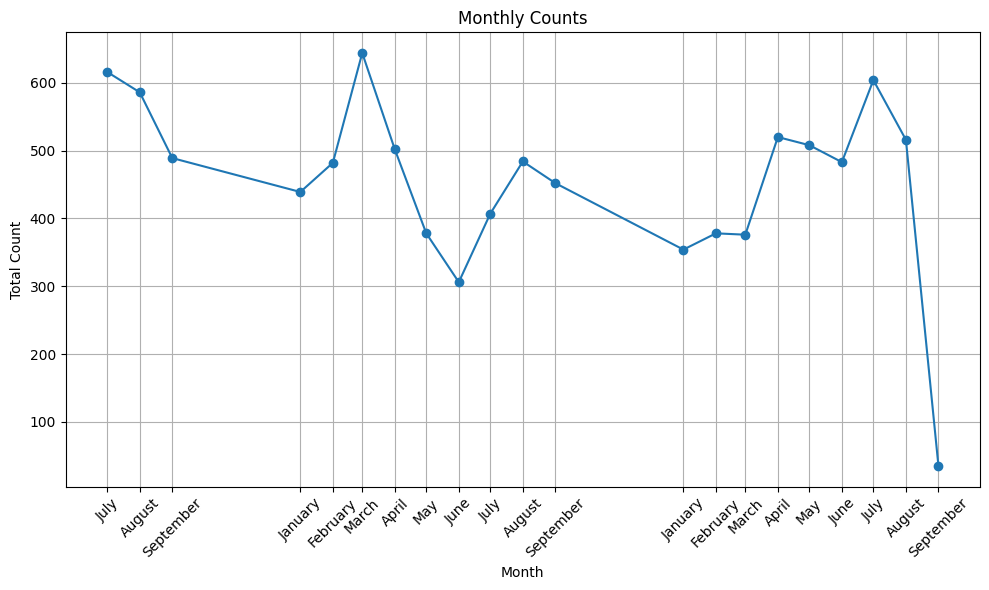

In [5]:

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(monthly_data.index.to_timestamp(), monthly_data['count'], marker='o')
plt.title('Monthly Counts')
plt.xlabel('Month')
plt.ylabel('Total Count')
plt.grid(True)
plt.xticks(monthly_data.index.to_timestamp(), monthly_data.index.to_timestamp().strftime('%B'), rotation=45)
plt.tight_layout()
plt.show()

## Chula Vista

Chula Vista is a divided city. The East side of Chula Vista is suburban — driving through, you’ll see large estates, gated communities, and lush golf courses. East Chula Vista has almost three and a half times the amount of park space that the city’s West side has, according to a 2021 report by a city watchdog group called the Growth Management Oversight Commission.   

“There’s a higher expectation of privacy here,” says one man, a retiree, standing in the driveway of his home near Bonita Long Canyon Park. He, like other residents on the East side interviewed for this story, says that while he is generally supportive of police drones, he appreciates that the city mostly flies above the people living West of Interstate 805 where there is more reported crime. As another man put it, the residents of the East have become accustomed to living in larger spaces with unobstructed views of the rolling hills. “They paid more for that luxury,” he says, pointing to the homes overlooking Discovery Park. 

The manager at a golf course on the East side was even more explicit. “Right now we’re sneaking up on chaos in a lot of areas,” he says, “and if drones are what’s needed to take care of the criminals,” so be it. 

“Buzz that son of a gun all you want to.”

The West side, on the other hand, is densely populated and residents tend to be poorer and born outside the United States. According to Census data, nearly half of households on the West side would qualify for the federal free and reduced lunch program — which is $48,000 annually for a family of four. Only 19% of households on the East side would qualify for this program, by comparison.  


### East versus West Demographics

In [6]:
cv_blocks["block-group-geoid"] = cv_blocks['GEOID20'].apply(lambda x: x[:12])
cv_blocks_race = pd.merge(cv_blocks,race_df,on='GEOID20')
cv_df = pd.merge(cv_blocks_race,poverty_df,on='block-group-geoid',how='left')

In [7]:
cv_bg = cv_df[['block-group-geoid','FRLP Households','% FRLP Eligible','% Below Median','Below Median Households','west_cv','Total_y']].drop_duplicates()

In [8]:
logger.info(f"{cv_bg[cv_bg['west_cv']=='True']['FRLP Households'].astype(float).sum()/cv_bg[cv_bg['west_cv']=='True']['Total_y'].astype(float).sum()} of households on the west side qualify for frlp")
logger.info(f"{cv_bg[cv_bg['west_cv']=='False']['FRLP Households'].astype(float).sum()/cv_bg[cv_bg['west_cv']=='False']['Total_y'].astype(float).sum()} of households on the east side qualify for frlp")

2024-05-20 10:04:26.747 | INFO     | __main__:<module>:1 - 0.48746809596733026 of households on the west side qualify for frlp
2024-05-20 10:04:26.749 | INFO     | __main__:<module>:2 - 0.193927224047706 of households on the east side qualify for frlp


### Calls for Service

Is there a relationship between calls for service and seconds spent on a block

2024-05-20 10:04:26.755 | INFO     | __main__:<module>:4 - Correlation coefficient: 0.408389781945344
2024-05-20 10:04:26.756 | INFO     | __main__:<module>:5 - There is a moderate `positive relationship between CFS and amount of times drones spend, but its not the strongest.  It means there are lots of outliers.


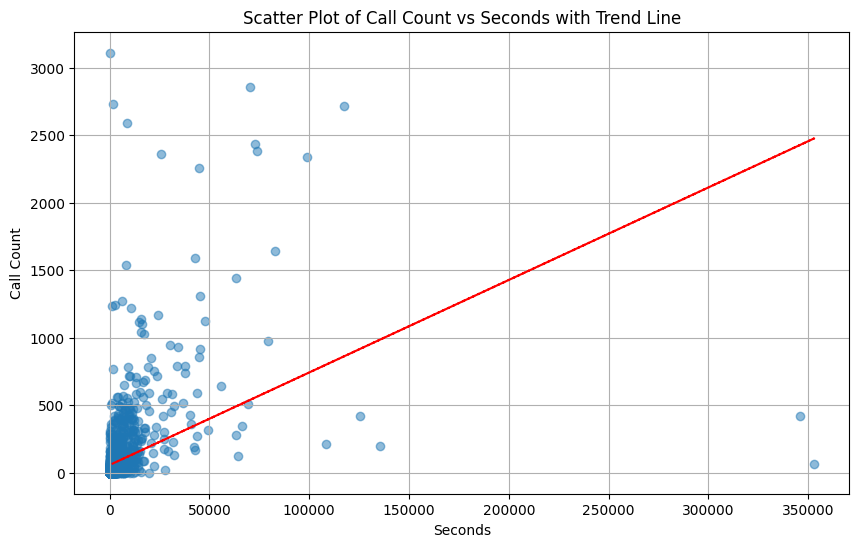

In [9]:
per_second['seconds'] = per_second['seconds'].astype(float)
per_second['call_count']  = per_second['call_count'].astype(float)
correlation = per_second['seconds'].corr(per_second['call_count'])
logger.info(f'Correlation coefficient: {correlation}')
logger.info(f'There is a moderate `positive relationship between CFS and amount of times drones spend, but its not the strongest.  It means there are lots of outliers.')

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(per_second['seconds'], per_second['call_count'], alpha=0.5)

# Trend line
z = np.polyfit(per_second['seconds'], per_second['call_count'], 1)
p = np.poly1d(z)
plt.plot(per_second['seconds'], p(per_second['seconds']), "r--")

# Labeling
plt.title('Scatter Plot of Call Count vs Seconds with Trend Line')
plt.xlabel('Seconds')
plt.ylabel('Call Count')
plt.grid(True)

# Show plot
plt.show()

In [10]:
from sklearn.linear_model import LinearRegression

# Fit a linear regression model
model = LinearRegression()
model.fit(per_second[['seconds']], per_second['call_count'])

# Predict the values
per_second['predicted_call_count'] = model.predict(per_second[['seconds']])

# Calculate residuals
per_second['residuals'] = per_second['call_count'] - per_second['predicted_call_count']

# Define a method to find outliers based on residuals
# For example, using 1.5 times the standard deviation
residual_std = per_second['residuals'].std()
outlier_threshold = 1.5 * residual_std

# Mark outliers in a new column
per_second['is_outlier'] = np.abs(per_second['residuals']) > outlier_threshold

In [18]:
per_day

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,MTFCC20,UR20,UACE20,UATYPE20,...,INTPTLAT20,INTPTLON20,HOUSING20,POP20,geometry,len,num_flights,flights_per_day,num_calls,calls_per_day
0,6,73,12600,1005,060730126001005,Block 1005,G5040,U,78661.0,U,...,32.6326934,-117.0972764,0,1,"POLYGON ((-117.09848 32.636082, -117.098118 32...",15,163,0.2058080808080808,0,0.0
1,6,73,12600,1000,060730126001000,Block 1000,G5040,U,78661.0,U,...,32.6327645,-117.0968738,0,1,"POLYGON ((-117.098419 32.636099, -117.098382 3...",15,207,0.26136363636363635,0,0.0
2,6,73,12600,1001,060730126001001,Block 1001,G5040,U,78661.0,U,...,32.627561,-117.0948246,0,1,"POLYGON ((-117.095692 32.629235, -117.095466 3...",15,131,0.16540404040404041,0,0.0
3,6,73,12600,1002,060730126001002,Block 1002,G5040,U,78661.0,U,...,32.6279724,-117.0932719,310,656,"POLYGON ((-117.095251 32.629345, -117.095177 3...",15,241,0.3042929292929293,1170,1.4772727272727273
4,6,73,12600,1003,060730126001003,Block 1003,G5040,U,78661.0,U,...,32.6284473,-117.0915697,39,94,"POLYGON ((-117.092611 32.630074, -117.092519 3...",15,221,0.27904040404040403,28,0.03535353535353535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1954,6,73,10016,1000,060730100161000,Block 1000,G5040,R,NaN,NaN,...,32.5937593,-116.9514464,0,1,"POLYGON ((-116.966156 32.589925, -116.965916 3...",15,1,0.0012626262626262627,0,0.0
1955,6,73,10016,1002,060730100161002,Block 1002,G5040,R,NaN,NaN,...,32.5850417,-116.9902654,0,1,"POLYGON ((-117.005217 32.592376, -117.005127 3...",15,2,0.0025252525252525255,0,0.0
1956,6,73,13322,3005,060730133223005,Block 3005,G5040,U,78661.0,U,...,32.6288505,-116.9924214,4,22,"POLYGON ((-116.993114 32.628806, -116.993053 3...",15,4,0.005050505050505051,8,0.010101010101010102
1957,6,73,13322,3000,060730133223000,Block 3000,G5040,U,78661.0,U,...,32.634625,-116.991596,162,575,"POLYGON ((-116.996325 32.633525, -116.996153 3...",15,56,0.0707070707070707,238,0.3005050505050505


In [17]:
per_day.columns

Index(['STATEFP20', 'COUNTYFP20', 'TRACTCE20', 'BLOCKCE20', 'GEOID20',
       'NAME20', 'MTFCC20', 'UR20', 'UACE20', 'UATYPE20', 'FUNCSTAT20',
       'ALAND20', 'AWATER20', 'INTPTLAT20', 'INTPTLON20', 'HOUSING20', 'POP20',
       'geometry', 'len', 'num_flights', 'flights_per_day', 'num_calls',
       'calls_per_day'],
      dtype='object')